100%|██████████| 500/500 [01:04<00:00,  7.75it/s]


Pixel Accuracy: 0.69%
Mean IoU: 0.49%
Class     IoU (%)   
0         0.00      
1         0.45      
2         1.14      
3         0.29      
4         4.09      
5         1.49      
6         0.00      
7         0.01      
8         0.34      
9         0.79      
10        0.00      
11        0.23      
12        0.09      
13        0.29      
14        0.00      
15        0.02      
16        0.00      
17        0.05      
18        0.10      
Estimated FLOPs per forward pass: 1.07e+16
Inference Time: 64.48 seconds
FPS: 7.75


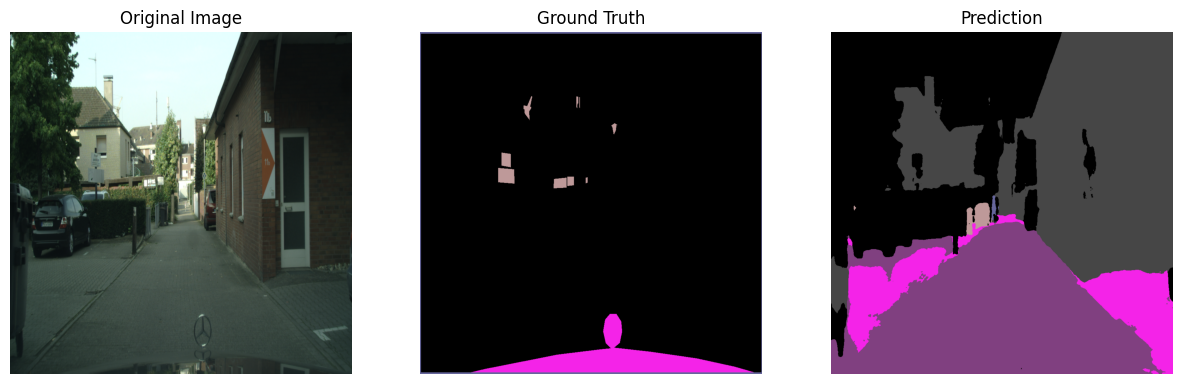

In [13]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import SegformerForSemanticSegmentation
from torchvision.transforms import Compose, ToTensor, Normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

class CityscapesDataset(Dataset):
    def __init__(self, image_dir, label_dir, num_classes, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.num_classes = num_classes
        self.image_files = []
        self.label_files = []

        # Collect all image and label file paths
        for city in os.listdir(image_dir):
            city_image_dir = os.path.join(image_dir, city)
            city_label_dir = os.path.join(label_dir, city)
            if os.path.isdir(city_image_dir) and os.path.isdir(city_label_dir):
                for img_file in os.listdir(city_image_dir):
                    if img_file.endswith('.png'):
                        self.image_files.append(os.path.join(city_image_dir, img_file))
                        label_file = img_file.replace('leftImg8bit', 'gtFine_labelIds')
                        label_mask_path = os.path.join(city_label_dir, label_file)

                        if not os.path.exists(label_mask_path):
                            for subfolder in os.listdir(city_label_dir):
                                possible_label_path = os.path.join(city_label_dir, subfolder, label_file)
                                if os.path.exists(possible_label_path):
                                    label_mask_path = possible_label_path
                                    break
                        
                        if os.path.exists(label_mask_path):
                            self.label_files.append(label_mask_path)
                        else:
                            print(f"Label mask for {img_file} not found.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Image at {img_path} could not be loaded.")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = self.label_files[idx]
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        if label is None:
            raise ValueError(f"Label at {label_path} could not be loaded.")

        image = cv2.resize(image, (1024, 1024))
        label = cv2.resize(label, (1024, 1024), interpolation=cv2.INTER_NEAREST)

        if self.transform:
            image = self.transform(image)

        label = np.array(label, dtype=np.int64)
        return image, label

# Number of classes for Cityscapes dataset
num_classes = 19

# Load the pretrained SegFormer B0 model
model_name = 'nvidia/segformer-b0-finetuned-cityscapes-1024-1024'
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Data transformations for input
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset and dataloader for Cityscapes
dataset = CityscapesDataset(
    image_dir="segment-anything-2/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val",
    label_dir="segment-anything-2/cityscapes/gtFine_trainvaltest/gtFine/val",
    num_classes=num_classes,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

# Inference and evaluation
all_predictions = []
all_labels = []

# Track inference time
start_time = time.time()

with torch.no_grad():
    for images, labels in tqdm(dataloader, mininterval=5.0):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(pixel_values=images)
        logits = outputs.logits

        # Resize logits to match image size (1024)
        upsampled_logits = torch.nn.functional.interpolate(
            logits,
            size=(1024, 1024),
            mode='bilinear',
            align_corners=False
        )

        predictions = upsampled_logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time
fps = len(dataloader.dataset) / inference_time  # Calculate FPS

torch.cuda.empty_cache()

# Function for evaluation metrics
def fast_hist(a, b, n):
    if a.shape != b.shape:
        raise ValueError(f"Shape mismatch: a.shape = {a.shape}, b.shape = {b.shape}")
    
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k].astype(int), minlength=n**2).reshape(n, n)

def compute_metrics(predictions, labels, num_classes):
    hist = np.zeros((num_classes, num_classes))
    for pred, label in zip(predictions, labels):
        if pred.shape != label.shape:
            print(f"Shape mismatch: pred.shape = {pred.shape}, label.shape = {label.shape}")
            continue
        hist += fast_hist(label.flatten(), pred.flatten(), num_classes)
    mIoU = per_class_iu(hist)
    pixel_acc = np.diag(hist).sum() / hist.sum()
    return mIoU, pixel_acc

def per_class_iu(hist):
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    return iu

# Calculate metrics
mIoU, pixel_acc = compute_metrics(all_predictions, all_labels, num_classes)

print(f"Pixel Accuracy: {pixel_acc * 100:.2f}%")
print(f"Mean IoU: {np.nanmean(mIoU) * 100:.2f}%")

# Per-class IoU table
print(f"{'Class':<10}{'IoU (%)':<10}")
for idx, iou in enumerate(mIoU):
    print(f"{idx:<10}{iou * 100:<10.2f}")

# Estimate FLOPs
# This is a simplified calculation; you may need a more sophisticated method for a precise FLOP count
flops = 2 * (1024 * 1024 * 256) * (1024 * 1024 * 19)  # This is a rough estimate for one forward pass
print(f"Estimated FLOPs per forward pass: {flops:.2e}")

# Print inference time and FPS
print(f"Inference Time: {inference_time:.2f} seconds")
print(f"FPS: {fps:.2f}")

# Visualization function
def visualize_predictions(images, labels, predictions, idx_to_color):
    for i in range(len(images)):
        image = images[i].cpu().numpy().transpose(1, 2, 0)
        image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        label = labels[i].cpu().numpy()
        prediction = predictions[i].cpu().numpy()

        label_color = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        prediction_color = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

        for cls_idx, color in idx_to_color.items():
            label_color[label == cls_idx] = color
            prediction_color[prediction == cls_idx] = color

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(label_color)
        axes[1].set_title('Ground Truth')
        axes[1].axis('off')

        axes[2].imshow(prediction_color)
        axes[2].set_title('Prediction')
        axes[2].axis('off')

        plt.show()

# Example class-to-color mapping (for Cityscapes dataset)
idx_to_color = {
    0: [128, 64, 128],   # Road
    1: [244, 35, 232],   # Sidewalk
    2: [70, 70, 70],     # Building
    3: [102, 102, 156],  # Wall
    4: [190, 153, 153],  # Fence
    # Add more class colors as needed
}

# Example: Visualize a few predictions
visualize_predictions(images, labels, predictions, idx_to_color)
